In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import partial
%matplotlib inline

In [46]:
class FindLanes:
    
    def __init__(self):
        self.search_start = -1
        self.search_end = -1
        self.error_counter = 0
        
    
    def compute_calibartion_points(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('./camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        self.objpoints = objpoints
        self.imgpoints = imgpoints


    def undistort_image(self, img):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, 
                                                           (img.shape[1], img.shape[0]),None,None)
        return cv2.undistort(img, mtx, dist, None, mtx)


    def binary_pipeline(self, img, s_thresh=(170, 255), sx_thresh=(20, 100)):
        img = np.copy(img)
        # Convert to HSV color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

        #combine
        color_binary = np.zeros_like(scaled_sobel)
        color_binary[(sxbinary == 1) | (s_binary ==1)] = 1
        return color_binary


    def warper(self, img):
        img_size = (img.shape[1], img.shape[0])
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
        return warped, Minv

    
    def get_histogram_points(self, binary_warped):
        if self.search_start == -1:
            search_start = 150
        else:
            search_start = self.search_start
        if self.search_end == -1:
            search_end = 1150
        else:
            search_end = min(self.search_end, binary_warped.shape[1])
        
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,search_start:search_end], axis=0)

        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = search_start + np.argmax(histogram[:midpoint])
        rightx_base = search_start + np.argmax(histogram[midpoint:]) + midpoint

        return midpoint, leftx_base, rightx_base
    

    def polynomial_pipeline(self, binary_warped, Minv, image, nwindows=9, margin=100, minpix=50):
        # histogram of bottom 1/2
        midpoint, leftx_base, rightx_base = self.get_histogram_points(binary_warped)
        if rightx_base - leftx_base < 700:
            self.search_start = -1
            self.search_end = -1
            midpoint, leftx_base, rightx_base = self.get_histogram_points(binary_warped)
        self.search_start = max(leftx_base - margin, 0)
        self.search_end = rightx_base + margin

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions. x and y values
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        left_curvature, right_curvature = self.get_curvature(binary_warped, lefty, leftx, righty, rightx)
        print(left_curvature)
        print(right_curvature)
        if (left_curvature > 10000 or right_curvature > 10000):
            cv2.imwrite("error.jpg", image)
            print("writtem error")
        plt.imshow(image)

        return self.plot_on_road(binary_warped, image, left_fitx, right_fitx, ploty, Minv)
    

    def plot_on_road(self, binary_warped, image, left_fitx, right_fitx, ploty, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        return cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    
    def process_image(self, img):
        undistort = self.undistort_image(img)
        binary = self.binary_pipeline(undistort)
        warped, Minv = self.warper(binary)
        on_road = self.polynomial_pipeline(warped, Minv, img)
        return on_road
    
    
    def get_binary_warped(self, img):
        undistort = self.undistort_image(img)
        binary = self.binary_pipeline(undistort)
        return self.warper(binary)
    
    
    def get_curvature(self, binary_warped, lefty, leftx, righty, rightx):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = binary_warped.shape[0]

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        return left_curverad, right_curverad

In [47]:
find_lanes = FindLanes()
find_lanes.compute_calibartion_points()

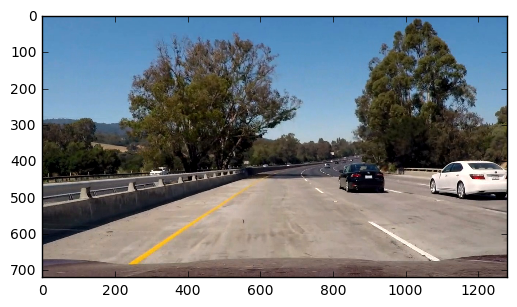

In [49]:
image = cv2.imread("error.jpg")
plt.imshow(image)

In [50]:
warped, minv = find_lanes.get_binary_warped(image)

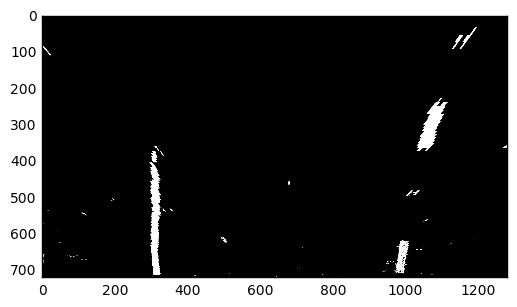

In [51]:
plt.imshow(warped, cmap="gray")

7583.01819507
662.599230403


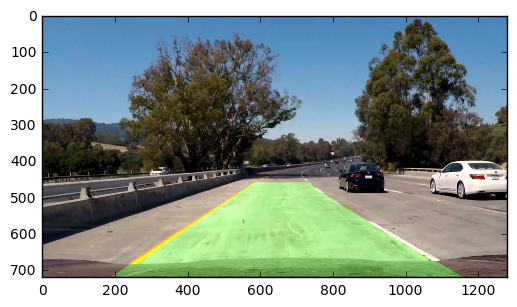

In [52]:
on_road = find_lanes.polynomial_pipeline(warped, minv, image)
plt.imshow(on_road)

## video

1137.76215555
2912.22703154
[MoviePy] >>>> Building video pve_lines.mp4
[MoviePy] Writing video pve_lines.mp4








  0%|          | 0/5 [00:00<?, ?it/s]





 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

1137.76215555
2912.22703154








 40%|████      | 2/5 [00:01<00:01,  1.54it/s]

1136.02194101
2495.41963076








 60%|██████    | 3/5 [00:01<00:01,  1.56it/s]

989.942783547
1904.86906803








 80%|████████  | 4/5 [00:02<00:00,  1.58it/s]

1219.22174127
2076.14505294
[MoviePy] Done.
[MoviePy] >>>> Video ready: pve_lines.mp4 

CPU times: user 6.02 s, sys: 227 ms, total: 6.25 s
Wall time: 2.67 s


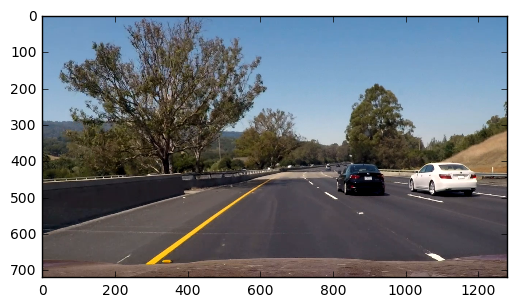

In [59]:
lanes_output = 'pve_lines.mp4'
clip1 = VideoFileClip("pve.mp4")
lanes_clip = clip1.fl_image(find_lanes.process_image) #NOTE: this function expects color images!!
%time lanes_clip.write_videofile(lanes_output, audio=False)

In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lanes_output))